# GAN met Fashion MNIST

In deze notebook gaan we opnieuw beelden genereren op basis van de Fashin MNIST dataset, net zoals in de vorige notebook over variational autoencoders (VAE). 
Hierbij moeten we een generator en discriminator opstellen.

## Importeren van packages en dataset

Eerst importeren we alle benodigde Python-bibliotheken voor het bouwen, trainen en visualiseren van onze VAE.
We gebruiken Pytorch voor het bouwen van het neurale netwerk, matplotlib voor visualisaties en NumPy voor numerieke berekeningen.
Daarna laden we de Fashion MNIST dataset, normaliseren de pixelwaarden naar de range [-1,1] 
en splitsen de dataset in een trainings- en testset. We gebruiken DataLoader om mini-batches te maken voor training.

In [3]:
# Importeren van benodigde bibliotheken
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# Controleer of er een GPU beschikbaar is, zo niet gebruik de CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data-transformatie: normaliseer de afbeeldingen zodat de pixelwaarden tussen -1 en 1 liggen
transform = transforms.Compose([
    transforms.ToTensor(),  # Converteert beeld naar tensor
    transforms.Normalize((0,), (1,))  # Hiermee kan je experimenteren maar moet in lijn liggen met de images die je genereert in de generator
])

# FashionMNIST dataset downloaden en laden
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

# DataLoader voor batches van de trainingsdata
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

print("Data geladen en DataLoader klaar.")

Data geladen en DataLoader klaar.


## Generator

 Deze cel definieert de generator die een random vector van ruis (latent vector) gebruikt om een afbeelding van 28x28 pixels te genereren. Het netwerk bestaat uit vier volledig verbonden lagen met ReLU-activatie, gevolgd door een Tanh activatie om de output te normaliseren.

In [4]:
# begint van ruis en maakt een beeldje
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential( # standaard fully-connected neuraal netwerk
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim),
            nn.Tanh() # activatiefunctie die gaat van -1 tot 1 en een s-curve heeft zoals een sigmoid
        )

    def forward(self,x):
        return self.model(x)

latent_dim = 100 # kan je kiesen (de dimensie van de ruisvector om van te starten
generator = Generator(latent_dim, output_dim = 28*28).to(device) # 28x28 is de dimensie van een fashion mnist beeldje

## Discriminator

Deze cel definieert de discriminator, die een afbeelding van 28x28 pixels als invoer ontvangt en een enkele waarde teruggeeft die aangeeft of de afbeelding echt is (uit de dataset) of vals (gegenereerd door de generator). Het netwerk bestaat uit vier volledig verbonden lagen met LeakyReLU-activatie en dropout om overfitting te voorkomen.

In [7]:
# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),  # flatten het mnist beeldje voor het aan dit model te geven
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Gebruik Sigmoid om de output te normaliseren naar het bereik [0, 1]
        )
        
    def forward(self, x):
        return self.model(x)

# Initialiseer de discriminator
discriminator = Discriminator(input_dim=28*28).to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


## Loss functions

In deze cel worden de verliesfunctie en de optimalizers voor de generator en discriminator gedefinieerd. We gebruiken binaire cross-entropy (BCELoss) als verliesfunctie en de Adam-optimizer voor zowel de generator als de discriminator.

In [8]:
# Verliesfunctie
criterion = nn.BCELoss() # de loss-functie van de discriminator (de generator heeft geen loss-functie want er is geen trainingsdata om de beelden mee te vergelijken)

# Optimalizers voor generator en discriminator
lr = 0.0002
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

## Trainen van het GAN model

De discriminator wordt getraind met zowel echte als gegenereerde afbeeldingen om te leren onderscheid te maken tussen de twee, terwijl de generator wordt getraind om betere afbeeldingen te genereren die de discriminator niet kan onderscheiden van echte. Voor elke epoch printen we het verlies van zowel de generator als de discriminator.

In [10]:
model_path_gen = "02_ganmodel_gen.pth"
model_path_discr = "02_ganmodel_dis.pth"

if os.path.exists(model_path_gen):
    print("Load existing model")

    generator.load_state_dict(torch.load(model_path_gen))
    generator.eval()

    discriminator.load_state_dict(torch.load(model_path_discr))
    discriminator.eval()
    
    print("Load done")
else:
    num_epochs = 10 
    for epoch in range(num_epochs):
        running_loss=0.0
        for n, (real_images, _) in enumerate(train_loader):
            # per batch van echte beeldjes in de trainingsdata
            # genereer ook een batch fake beeldjes
            # train beide modellen

            generator.train()
            discriminator.train()

            # real_images.size(0) is de batch size
            # real_images.size -> (batch_size, channels, width, height) (RGB figuurtje)
            # real_images.shape[0]
            real_images.view(real_images.size(0), -1).to(device) # flatten de images van 2d naar 1d
            real_labels = torch.ones(real_images.size(0), 1).to(device)

            # train de discriminator met de echte beeldjes
            optimizer_D.zero_grad()
            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()

            # genereer fake beeldjes
            noise = torch.randn(real_images.size(0), latent_dim).to(device)
            fake_images = generator(noise)
            fake_labels = torch.zeros(real_images.size(0), 1).to(device)

            # train de discriminator met de fake beeldjes
            outputs = discriminator(fake_images)
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()
            optimizer_D.step()

            # total loss
            d_loss = d_loss_real + d_loss_fake

            # trainen van de generator
            optimizer_G.zero_grad()
            outputs = discriminator(fake_images)    # classificeer de fake-beeldjes opnieuw na trainen van de descriminator (wordt gebruikt om de generator te trainen)
            g_loss = criterion(outputs, real_labels) # we wouden dat de fake_images echte waren (real_labels in de loss_functie)
            g_loss = backward()
            optimizer_G.step()

        print(f"Epoch {epoch}/{num_epochs}")
    
    mode.eval()
    
    # save the model
    torch.save(discriminator.state_dict(), model_path_discr)
    torch.save(generator.state_dict(), model_path_gen)
    print("Model saved")

Load existing model
Load done


## Visualiseren van de resultaten

Deze cel definieert een functie om enkele gegenereerde afbeeldingen van de getrainde generator te visualiseren. Het genereert willekeurige ruis en laat de generator nieuwe afbeeldingen maken, die vervolgens worden weergegeven met behulp van Matplotlib.

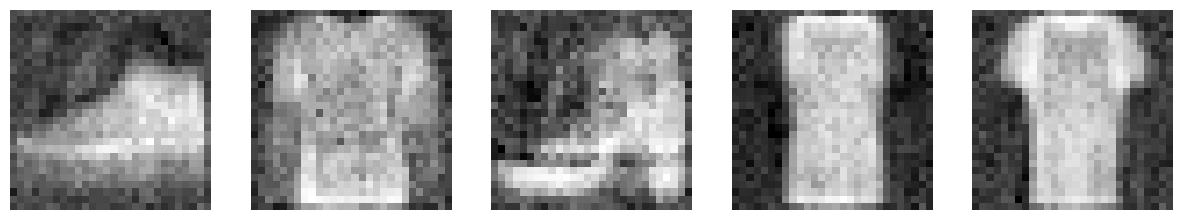

In [18]:
generator.eval()
noise = torch.randn(5, latent_dim).to(device)
with torch.no_grad():
    generated_images = generator(noise).cpu().view(5, 28, 28) # om de 1d-vector om te zetten naar een 28x28 figuurtje

fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i in range(5):
    axes[i].imshow(generated_images[i], cmap='gray')
    axes[i].axis('off')

plt.show()